In [15]:
!pip install gensim
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import gensim.downloader as api
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import numpy as np

# Prep

In [21]:
# Ustawienia
max_features = 20000  # liczba najczęściej występujących słów
maxlen = 100          # maksymalna długość recenzji

# Załaduj dane
print("Ładowanie danych IMDB...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Liczba próbek treningowych: {len(x_train)}")
print(f"Liczba próbek testowych: {len(x_test)}")


Ładowanie danych IMDB...
Liczba próbek treningowych: 25000
Liczba próbek testowych: 25000


In [22]:
# Import słowników
word_index = imdb.get_word_index()
# Dodajemy przesunięcie o 3, ponieważ Keras rezerwuje indeksy 0-3
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3


reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Przykładowe odkodowanie pierwszych 3 recenzji treningowych
for i in range(3):
    print(f"Recenzja {i+1}:")
    print(decode_review(x_train[i]))
    print("\n" + "-"*50 + "\n")


Recenzja 1:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

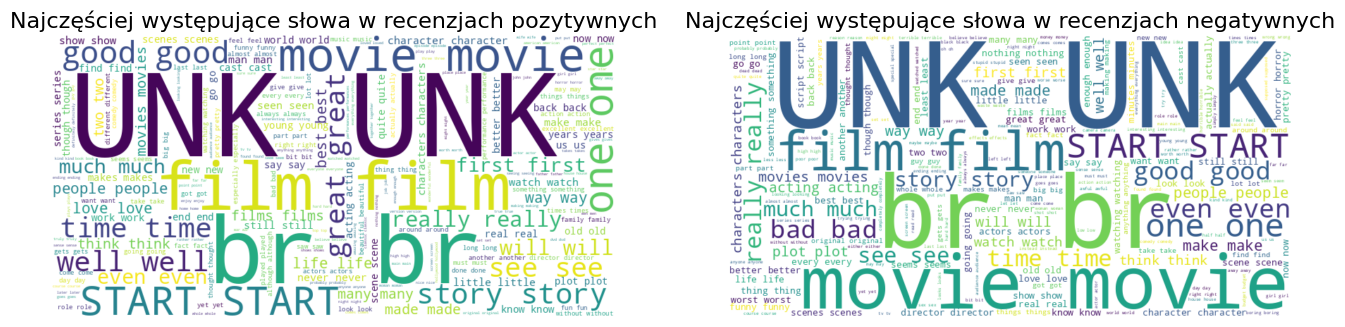

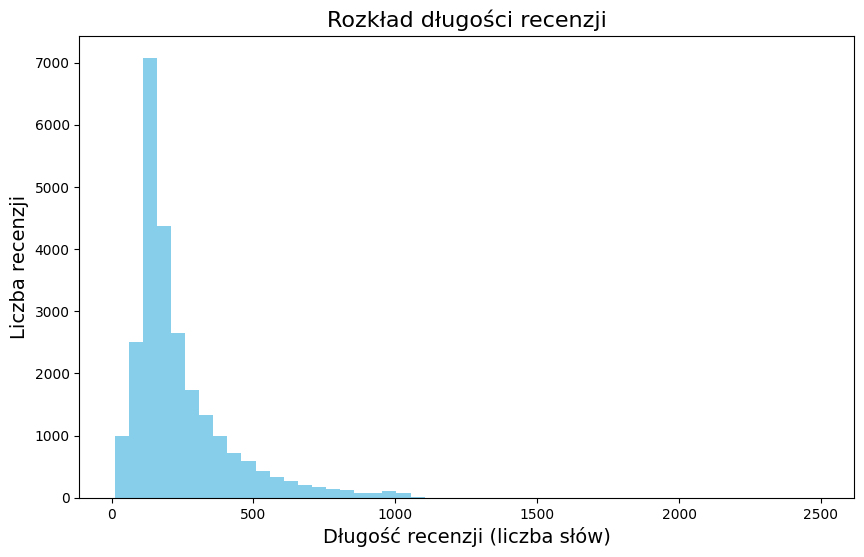

In [23]:
# Rozdzielenie recenzji na pozytywne i negatywne
positive_reviews = [x for x, y in zip(x_train, y_train) if y == 1]
negative_reviews = [x for x, y in zip(x_train, y_train) if y == 0]

# Funkcja do zliczania słów
def get_word_counts(reviews):
    counts = Counter()
    for review in reviews:
        counts.update(review)
    return counts

positive_counts = get_word_counts(positive_reviews)
negative_counts = get_word_counts(negative_reviews)

# Konwersja liczników na słownik z tekstem
positive_words = ' '.join([reverse_word_index.get(word_id, '?') for word_id in positive_counts.elements()])
negative_words = ' '.join([reverse_word_index.get(word_id, '?') for word_id in negative_counts.elements()])

# Tworzenie chmur słów
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Wizualizacja chmur słów
plt.figure(figsize=(16, 8))

# Chmura słów dla recenzji pozytywnych
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Najczęściej występujące słowa w recenzjach pozytywnych', fontsize=16)
plt.axis('off')

# Chmura słów dla recenzji negatywnych
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Najczęściej występujące słowa w recenzjach negatywnych', fontsize=16)
plt.axis('off')

plt.show()

# Rozkład długości recenzji
review_lengths = [len(review) for review in x_train]

plt.figure(figsize=(10,6))
plt.hist(review_lengths, bins=50, color='skyblue')
plt.title("Rozkład długości recenzji", fontsize=16)
plt.xlabel("Długość recenzji (liczba słów)", fontsize=14)
plt.ylabel("Liczba recenzji", fontsize=14)
plt.show()


Aby model mógł efektywnie przetwarzać dane, musimy upewnić się, że wszystkie recenzje mają jednakową długość. Użyjemy funkcji pad_sequences z Keras, aby przyciąć lub wypełnić recenzje.

In [24]:
# Przygotowanie danych treningowych i testowych
print("Przygotowanie danych za pomocą pad_sequences...")
x_train_padded = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

print(f"Przykładowa recenzja po paddingu: {x_train_padded[0]}")


Przygotowanie danych za pomocą pad_sequences...
Przykładowa recenzja po paddingu: [    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16]


# LSTM

In [25]:
# Parametry modelu
embedding_dim = 128

# Parametry modelu
embedding_dim = 128  # Możesz również użyć 64
hidden_units = 64    # Liczba neuronów w warstwie LSTM i Dense

# Budowa modelu
model = Sequential()
# Warstwa Embedding: przekształca indeksy słów na wektory o wymiarze `embedding_dim`
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))
# Warstwa LSTM: przetwarza sekwencje wektorów z warstwy Embedding
model.add(LSTM(hidden_units))
# Warstwa w pełni połączona (Dense): dodaje możliwość modelowania nieliniowych zależności
model.add(Dense(hidden_units, activation='relu'))
# Warstwa wyjściowa: pojedynczy neuron z aktywacją sigmoid dla binarnej klasyfikacji
model.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Wyświetlenie podsumowania modelu
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Rozpoczynanie treningu modelu...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.6107 - loss: 0.6272 - val_accuracy: 0.8050 - val_loss: 0.4365
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.8728 - loss: 0.3214 - val_accuracy: 0.8370 - val_loss: 0.3894
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.9278 - loss: 0.1968 - val_accuracy: 0.8318 - val_loss: 0.4322
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9526 - loss: 0.1378 - val_accuracy: 0.8154 - val_loss: 0.6496
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.9658 - loss: 0.0962 - val_accuracy: 0.8264 - val_loss: 0.5926
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 232ms/step - accuracy: 0.9800 - loss: 0.0621 - val_accuracy: 0.8202 - val_loss: 0.6227
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.9860 - loss: 0.0470 - val_accuracy: 0.8132 - val_loss: 0.8139
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/

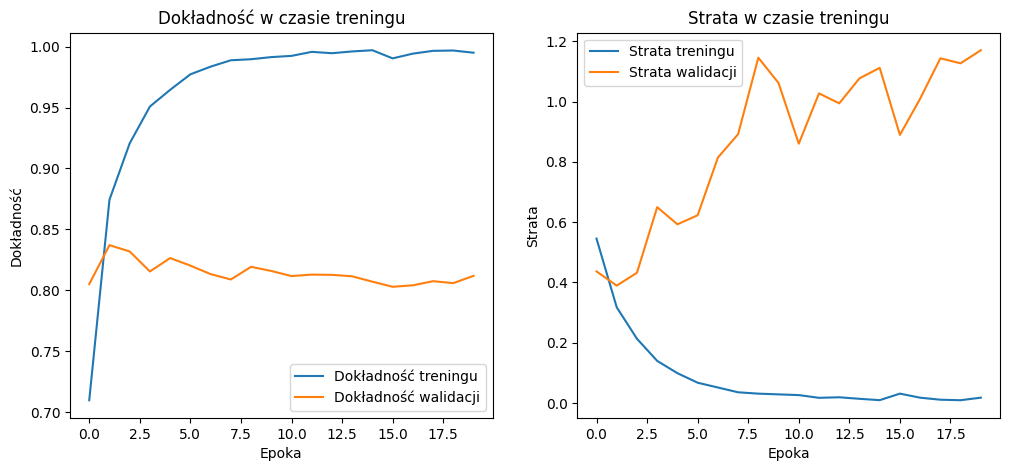

In [26]:
# Trenowanie modelu
epochs = 20
batch_size = 128

print("Rozpoczynanie treningu modelu...")
history = model.fit(x_train_padded, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

# Wizualizacja dokładności
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Dokładność treningu')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacji')
plt.title('Dokładność w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

# Wizualizacja straty
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Strata treningu')
plt.plot(history.history['val_loss'], label='Strata walidacji')
plt.title('Strata w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.show()


Rozpoczynanie treningu z Early Stopping...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.9985 - loss: 0.0065 - val_accuracy: 0.7718 - val_loss: 1.2844
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.9846 - loss: 0.0482 - val_accuracy: 0.8072 - val_loss: 1.1240
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.8114 - val_loss: 1.2248
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accuracy: 0.8014 - val_loss: 1.0295
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.9970 - loss: 0.0077 - val_accuracy: 0.8034 - val_loss: 1.1933
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.8126 - val_loss: 1.4162
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.8114 - val_loss: 1.3465


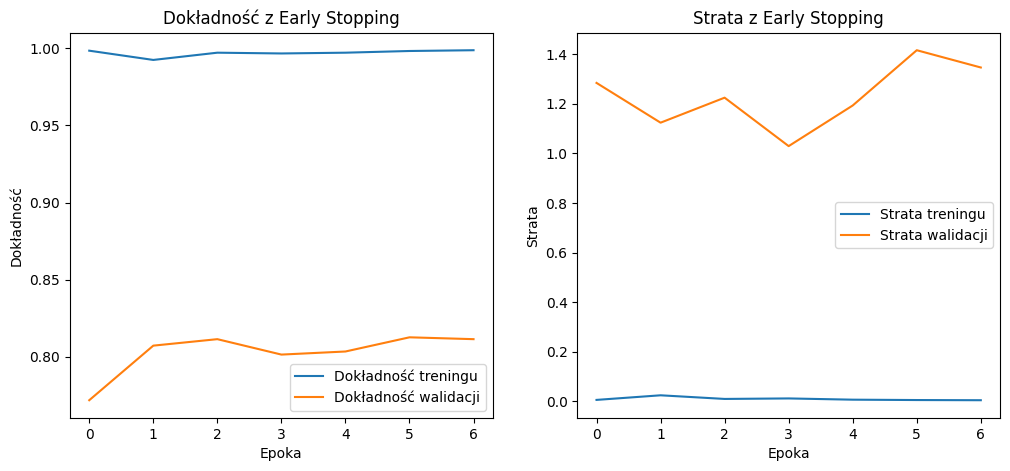

In [27]:
# Definicja callbacka EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Ponowne trenowanie modelu z Early Stopping
epochs = 20  # trzening może zostać przerwany wcześniej
print("Rozpoczynanie treningu z Early Stopping...")
history = model.fit(x_train_padded, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[early_stop])

# Wizualizacja wyników
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Dokładność treningu')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacji')
plt.title('Dokładność z Early Stopping')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Strata treningu')
plt.plot(history.history['val_loss'], label='Strata walidacji')
plt.title('Strata z Early Stopping')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.show()


In [28]:
# Funkcja do przygotowania tekstu
def prepare_text(text, word_index, maxlen):
    # Tokenizacja
    tokens = keras.preprocessing.text.text_to_word_sequence(text)
    # Konwersja słów na indeksy
    indices = [word_index.get(word, 2) for word in tokens]  # 2 = <UNK>
    indices = [index if index < max_features else 2 for index in indices]
    # Padding
    padded = pad_sequences([indices], maxlen=maxlen, padding='post', truncating='post')
    return padded

# Przykładowe wpisy
sample_texts = [
    "i love this movie it’s wonderful",
    "easily the most stellar experience i have ever had",
    "i had a really bad experience with the customer service"
]

# Przygotowanie tekstów
prepared_texts = [prepare_text(text, word_index, maxlen) for text in sample_texts]

# Predykcje
predictions = [model.predict(text)[0][0] for text in prepared_texts]

# Interpretacja wyników
for text, pred in zip(sample_texts, predictions):
    sentiment = "Pozytywny" if pred >= 0.5 else "Negatywny"
    print(f"Tekst: \"{text}\"")
    print(f"Przewidywane prawdopodobieństwo pozytywnego sentymentu: {pred:.4f} -> {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tekst: "i love this movie it’s wonderful"
Przewidywane prawdopodobieństwo pozytywnego sentymentu: 0.9236 -> Pozytywny

Tekst: "easily the most stellar experience i have ever had"
Przewidywane prawdopodobieństwo pozytywnego sentymentu: 0.9822 -> Pozytywny

Tekst: "i had a really bad experience with the customer service"
Przewidywane prawdopodobieństwo pozytywnego sentymentu: 0.2749 -> Negatywny



Pobieranie pretrenowanych wektorów GloVe...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

None
Trenowanie modelu z pretrenowanymi embeddingami...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.5814 - loss: 0.6647 - val_accuracy: 0.7526 - val_loss: 0.5197
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.7420 - loss: 0.5262 - val_accuracy: 0.7634 - val_loss: 0.4868
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.7648 - loss: 0.4866 - val_accuracy: 0.7776 - val_loss: 0.4685
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.7794 - loss: 0.4615 - val_accuracy: 0.7862 - val_loss: 0.4532
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.8003 - loss: 0.4305 - val_accuracy: 0.7946 - val_loss: 0.4381
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.8129 - loss: 0.4137 - val_accuracy: 0.8082 - val_loss: 0.4195
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.8131 - loss: 0.4064 - val_accuracy: 0.8056 - val_loss: 0.4267
Epoch 8/10
157/157 ━━━━━━━━

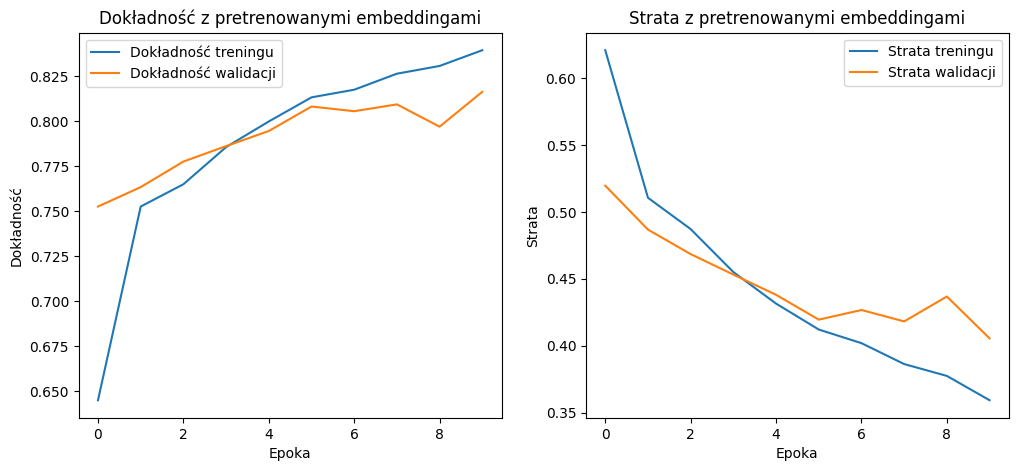

In [29]:
# Pobranie pretrenowanych wektorów GloVe (twitter.100d)
print("Pobieranie pretrenowanych wektorów GloVe...")
glove_vectors = api.load("glove-twitter-100")  # 100-dymensjonalne wektory

# Przygotowanie macierzy Embedding
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, index in word_index.items():
    if index < max_features:
        if word in glove_vectors:
            embedding_matrix[index] = glove_vectors[word]
        else:
            # Inicjalizacja losowa dla słów nieznanych w GloVe
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Budowa modelu z pretrenowanymi embeddingami
model_pretrained = Sequential()
model_pretrained.add(Embedding(input_dim=max_features,
                               output_dim=embedding_dim,
                               input_length=maxlen,
                               weights=[embedding_matrix],
                               trainable=False))  # Ustawiamy na False, aby nie trenować embeddingów
model_pretrained.add(LSTM(64))
model_pretrained.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
model_pretrained.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

print(model_pretrained.summary())

# Trenowanie modelu z pretrenowanymi embeddingami
print("Trenowanie modelu z pretrenowanymi embeddingami...")
history_pretrained = model_pretrained.fit(x_train_padded, y_train,
                                          epochs=10,
                                          batch_size=128,
                                          validation_split=0.2,
                                          callbacks=[early_stop])

# Wizualizacja wyników
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_pretrained.history['accuracy'], label='Dokładność treningu')
plt.plot(history_pretrained.history['val_accuracy'], label='Dokładność walidacji')
plt.title('Dokładność z pretrenowanymi embeddingami')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_pretrained.history['loss'], label='Strata treningu')
plt.plot(history_pretrained.history['val_loss'], label='Strata walidacji')
plt.title('Strata z pretrenowanymi embeddingami')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.show()
